# Tests on kooplearn contexts

## Setup

In [1]:
import os
from urllib.request import urlretrieve
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.gaussian_process.kernels import RBF
from kooplearn.models import NystroemKernel
from kooplearn.data import traj_to_contexts

In [2]:
base_url = "http://ftp.imp.fu-berlin.de/pub/cmb-data/"
files = [
    "alanine-dipeptide-3x250ns-backbone-dihedrals.npz",
    "alanine-dipeptide-3x250ns-heavy-atom-distances.npz",
]
for file in files:
    if not os.path.isfile(file):
        urlretrieve(base_url + file, file)

In [3]:
train_distances = np.load(files[1])["arr_0"]
test_distances = np.load(files[1])["arr_1"]
test_dihedrals = np.load(files[0])["arr_1"]
time_ns = np.arange(train_distances.shape[0], dtype=np.float64)*1e-3

In [4]:
train_distances.shape, test_distances.shape, test_dihedrals.shape

((250000, 45), (250000, 45), (250000, 2))

In [11]:
np.max(train_distances, axis=0), np.min(train_distances, axis=0)

(array([0.16542539, 0.25761116, 0.2650263 , 0.40649977, 0.51767683,
        0.52213657, 0.6335724 , 0.63606346, 0.7668032 , 0.13346592,
        0.14470784, 0.26848575, 0.3985185 , 0.3983631 , 0.503938  ,
        0.51019394, 0.64584684, 0.24482848, 0.32479197, 0.46959245,
        0.4599611 , 0.5593314 , 0.5604116 , 0.7011544 , 0.16022772,
        0.26687926, 0.27846828, 0.38813657, 0.39605895, 0.5289462 ,
        0.16655867, 0.16794391, 0.2617665 , 0.2693435 , 0.41143337,
        0.28141323, 0.39040017, 0.40425038, 0.5337195 , 0.13503537,
        0.1467071 , 0.27165842, 0.24260852, 0.32307303, 0.1603161 ],
       dtype=float32),
 array([0.13558012, 0.21683389, 0.22151074, 0.35577866, 0.3899803 ,
        0.38566938, 0.33963296, 0.37027943, 0.4212306 , 0.11157611,
        0.12215765, 0.22717822, 0.28384054, 0.27951068, 0.27757603,
        0.28257385, 0.37672913, 0.20463167, 0.25290757, 0.2846703 ,
        0.25922328, 0.26122114, 0.25793356, 0.3240419 , 0.13304894,
        0.21784638, 0.22

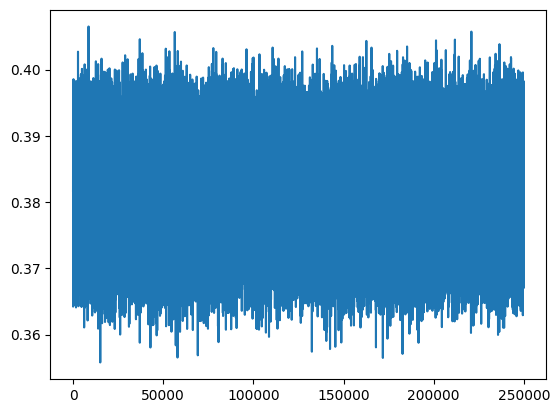

In [9]:
plt.plot(range(len(train_distances)), train_distances[:, 3])

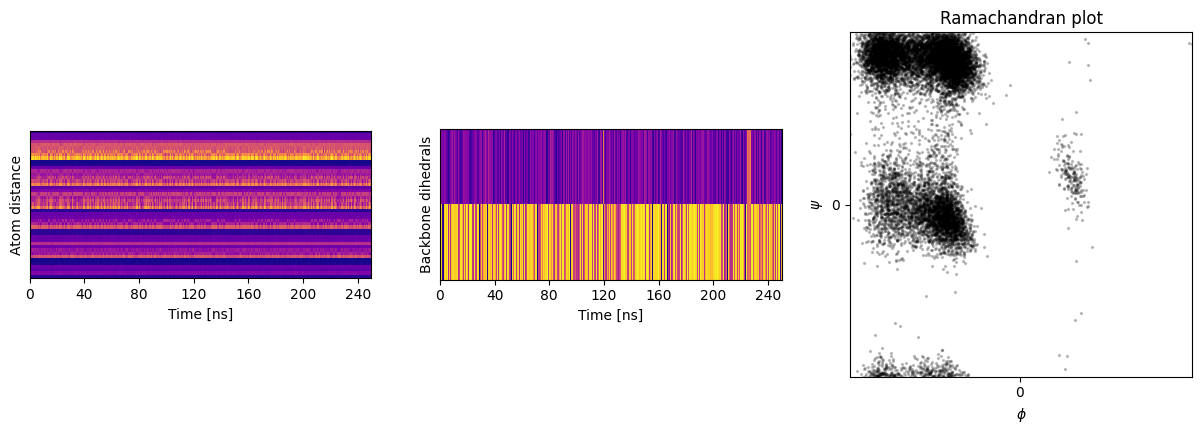

In [ ]:
subsample = 20

x_ticks = np.arange(len(test_distances[::subsample]))[::2000]
x_tickslabels = [f"{x:.0f}" for x in (time_ns[::subsample])[::2000]]

fig, ax = plt.subplots(ncols=3, figsize=(15, 9))
ax[0].imshow(test_distances[::subsample, :].T, aspect=120, cmap='plasma', interpolation='nearest')
ax[0].set_ylabel("Atom distance")
ax[0].set_xlabel("Time [ns]")
ax[0].set_yticks([], [])
ax[0].set_xticks(x_ticks, x_tickslabels)
ax[1].imshow(test_dihedrals[::subsample, :].T, aspect=2750, cmap='plasma', interpolation='nearest')
ax[1].set_ylabel("Backbone dihedrals")
ax[1].set_xlabel("Time [ns]")
ax[1].set_yticks([], [])
ax[1].set_xticks(x_ticks, x_tickslabels)

ax[2].scatter(test_dihedrals[::20, 0], test_dihedrals[::20, 1], s=2, color = 'k', alpha = 0.2)
ax[2].set_xlabel("$\phi$")
ax[2].set_ylabel("$\psi$")
ax[2].set_xticks([-np.pi, 0, np.pi], ["$-\pi$", "$0$", "$\pi$"])
ax[2].set_yticks([-np.pi, 0, np.pi], ["$-\pi$", "$0$", "$\pi$"])
ax[2].set_title("Ramachandran plot")
ax[2].margins(0)
ax[2].set_aspect('equal')

## Model training

 - `tr_dist_ctx`: the training context (x and y). This uses atom distances
 - `ts_dist_ctx`: the test context (x and y) using atom distances
 - `ts_dih_ctx`: an auxiliary *test* context which contains dihedrals instead of atom distances

In [75]:
def build_contexts(time_lag: int, subsample: int):
    tr_dist_ctx = traj_to_contexts(train_distances[::subsample], time_lag=time_lag)
    ts_dist_ctx = traj_to_contexts(test_distances[::subsample], time_lag=time_lag)
    ts_dih_ctx = traj_to_contexts(test_dihedrals[::subsample], time_lag=time_lag)
    return tr_dist_ctx, ts_dist_ctx, ts_dih_ctx

In [76]:
train_distances.shape

(250000, 45)

In [77]:
end = 50
trajectory = train_distances[:end]

In [78]:
trajectory.shape

(50, 45)

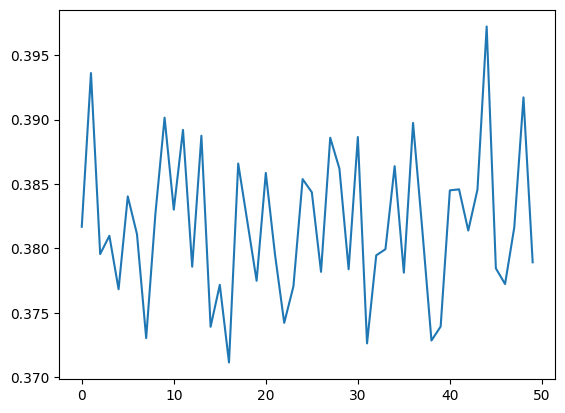

In [79]:
plt.plot(range(end), trajectory[:,3])

In [127]:
time_lag = 2
context_window_length = 10
tr_dist_ctx = traj_to_contexts(trajectory, time_lag=time_lag, context_window_len=context_window_length)

In [135]:
tr_dist_ctx.shape

(32, 10, 45)

In [148]:
trajectory[:10, 1]

array([0.23019415, 0.24490452, 0.24358162, 0.24254313, 0.23432022,
       0.23789527, 0.23574975, 0.23755814, 0.23857465, 0.2321146 ],
      dtype=float32)

In [147]:
tr_dist_ctx.data[0, :, 1]

array([0.23019415, 0.24358162, 0.23432022, 0.23574975, 0.23857465,
       0.23410083, 0.24121313, 0.23060383, 0.23282166, 0.2347982 ],
      dtype=float32)

In [153]:
tr_dist_ctx.lookback(5)[0, :, 1]

array([0.23019415, 0.24358162, 0.23432022, 0.23574975, 0.23857465],
      dtype=float32)

In [168]:
tr_dist_ctx.lookforward(5)[0, :, 1]

array([0.23410083, 0.24121313, 0.23060383, 0.23282166, 0.2347982 ],
      dtype=float32)

In [149]:
tr_dist_ctx.data[1, :, 1]

array([0.24490452, 0.24254313, 0.23789527, 0.23755814, 0.2321146 ,
       0.23488449, 0.24264216, 0.24085262, 0.24188007, 0.23992886],
      dtype=float32)

In [152]:
tr_dist_ctx.lookback(4)[1, :, 1]

array([0.24490452, 0.24254313, 0.23789527, 0.23755814], dtype=float32)

In [112]:
end = 10

In [113]:
tr_dist_ctx.data[:end, 0, 1]

array([0.23019415, 0.24490452, 0.24358162, 0.24254313, 0.23432022,
       0.23789527, 0.23574975, 0.23755814, 0.23857465, 0.2321146 ],
      dtype=float32)

In [114]:
tr_dist_ctx.data[:end, 1, 1]

array([0.24254313, 0.23432022, 0.23789527, 0.23574975, 0.23755814,
       0.23857465, 0.2321146 , 0.23410083, 0.23488449, 0.24121313],
      dtype=float32)

In [116]:
tr_dist_ctx.data[:end, 2, 1]

array([0.23574975, 0.23755814, 0.23857465, 0.2321146 , 0.23410083,
       0.23488449, 0.24121313, 0.24264216, 0.23060383, 0.24085262],
      dtype=float32)

In [118]:
tr_dist_ctx.data[:end, 3, 1]

array([0.2321146 , 0.23410083, 0.23488449, 0.24121313, 0.24264216,
       0.23060383, 0.24085262, 0.23282166, 0.24188007, 0.2347982 ],
      dtype=float32)

### Tropical cyclone data

In [25]:
import logging
import os
import random

import numpy as np
import torch
from absl import app
from kooplearn.models import Kernel, NystroemKernel
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split

from klearn_tcyclone.climada.tc_tracks import TCTracks
from klearn_tcyclone.data_utils import (
    LinearScaler,
    characteristic_length_scale_from_TCTracks,
)
from klearn_tcyclone.klearn_tcyclone import ModelBenchmark
from klearn_tcyclone.KNF.modules.eval_metrics import (
    RMSE_OneStep_TCTracks,
)
from klearn_tcyclone.training_utils.args import FLAGS
from klearn_tcyclone.training_utils.training_utils import set_flags

import logging
from typing import Union

# import numpy as np
import torch
from numpy import log10, logspace

from klearn_tcyclone.data_utils import (
    context_dataset_from_TCTracks,
    standardize_TensorContextDataset,
)
from klearn_tcyclone.models_utils import runner

In [26]:
year_range = [1990, 2000]

In [27]:
# Datasets
tc_tracks = TCTracks.from_ibtracs_netcdf(
    provider="usa",
    year_range=year_range,
    basin="NA",
    correct_pres=False,
)

2024-11-10 11:31:17,483 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file C:\Users\Eric\climada\data\IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-11-10 11:31:18,383 - climada.hazard.tc_tracks - WARNING - 4 storm events are discarded because no valid wind/pressure values have been found: 1990145N19276, 1990262N15315, 1991187N23264, 1991241N11329.


d:\work\projects\repositories\koopman_learning_tropical_cyclone\.venv\Lib\site-packages\climada\hazard\tc_tracks.py:614: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


In [28]:
tc_tracks

In [31]:
# TODO also generate a validation set
tc_tracks_train, tc_tracks_test = train_test_split(
    tc_tracks.data, test_size=0.1, random_state=42
)

In [ ]:
feature_list= ["lon", "lat", "max_sustained_wind"]
context_length = 13

In [170]:
tc_tracks_train[5]

<xarray.Dataset> Size: 3kB
Dimensions:                 (time: 59)
Coordinates:
  * time                    (time) datetime64[ns] 472B 1992-09-21T18:00:00 .....
    lat                     (time) float32 236B 30.0 30.12 30.3 ... 48.26 49.5
    lon                     (time) float32 236B -33.0 -33.34 ... -14.7 -13.5
Data variables:
    radius_max_wind         (time) float32 236B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    radius_oci              (time) float32 236B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    max_sustained_wind      (time) float32 236B 25.0 27.0 30.0 ... 42.0 45.0
    central_pressure        (time) float32 236B 1.012e+03 1.011e+03 ... 980.0
    environmental_pressure  (time) float64 472B 1.012e+03 1.011e+03 ... 1.01e+03
    time_step               (time) float64 472B 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0
    basin                   (time) <U2 472B 'NA' 'NA' 'NA' ... 'NA' 'NA' 'NA'
Attributes:
    max_sustained_wind_unit:  kn
    central_pressure_unit:    mb
    orig_event_flag:          True
    data_provider:            ibtracs_usa
    category:                 2
    name:                     CHARLEY
    sid:                      1992266N30327
    id_no:                    1992266030327.0

In [171]:
from klearn_tcyclone.data_utils import data_array_list_from_TCTracks
from kooplearn.data import TensorContextDataset, TrajectoryContextDataset

In [190]:
data_array_list = data_array_list_from_TCTracks(
    tc_tracks=tc_tracks, feature_list=feature_list
)

In [191]:
data_array_list[3].shape

(87, 3)

In [194]:
data_array_list[3].shape

(87, 3)

In [195]:
data_array = data_array_list[3]

In [196]:
data_array.shape

(87, 3)

In [201]:
time_lag = 1

In [202]:
traj_cd = TrajectoryContextDataset(
    data_array, context_length, time_lag,
)

In [203]:
context_length, time_lag

(13, 1)

In [204]:
traj_cd.shape

(75, 13, 3)

In [205]:

context_data_array = np.empty((0, context_length, len(feature_list)))
for idx, data_array in enumerate(data_array_list):
    if data_array.shape[0] >= context_length:
        context_data_array = np.concatenate(
            [
                context_data_array,
                TrajectoryContextDataset(
                    data_array, context_length, time_lag,
                ).data,
            ],
            axis=0,
        )

In [206]:
context_data_array.shape

(6758, 13, 3)

In [208]:
tensor_context_dataset = TensorContextDataset(
    context_data_array,
)

In [209]:
tensor_context_dataset.shape

(6758, 13, 3)

In [33]:
tensor_context_train = context_dataset_from_TCTracks(
    tc_tracks_train,
    feature_list=features,
    context_length=context_length,
)
tensor_context_test = context_dataset_from_TCTracks(
    tc_tracks_test,
    feature_list=features,
    context_length=context_length,
)

In [35]:
tensor_context_train.shape

(6020, 13, 3)

In [42]:
tensor_context_train[0].lookback(4).shape

(1, 4, 3)